In [1]:
%load_ext autoreload
%autoreload 2


- Two major problems
  - Spatial data (and others) has no fixed reference. There should be a transform/rot/scale lstsq after main pinning
  - There is no current incentive for cells to interact with an absolute env

In [2]:
import logging
import os

import manim as ma
import matplotlib as mpl
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import torch
import umap

import celltrip

# No verbose fsspec
logging.getLogger('botocore.tokens').setLevel(logging.CRITICAL)
logging.getLogger('fsspec').setLevel(logging.CRITICAL)

# Environment
os.environ['AWS_PROFILE'] = 'waisman-admin'
mpl.rcParams['pdf.fonttype'] = mpl.rcParams['ps.fonttype'] = 42
sns.set_theme(context='paper', style='dark', palette='colorblind')


In [3]:
import logging
logging.getLogger('boto3').setLevel(logging.ERROR)

import logging
logging.getLogger('boto3').propagate = False

# Running the Model

In [4]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/MERFISH/expression.h5ad',
#     's3://nkalafut-celltrip/MERFISH/spatial.h5ad',
#     backed=True)
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/MERFISH-250825', 400
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index
# m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(env, pinning_spatial=[1]).eval().to('cuda')  # pinning_modal_dims=None for lstq pinning
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [5]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/MERFISH_Bench/expression.h5ad',
#     's3://nkalafut-celltrip/MERFISH_Bench/spatial.h5ad',
#     backed=True)
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/MERFISH_Bench-250807', 300
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index
# m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(env).eval().to('cuda')  # pinning_modal_dims=None for lstq pinning
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [6]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/VirtualCell/vcc_flt_data.h5ad',
#     backed=True)
# # Model location and name (should be prefix for .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/VCC-250822-1', 800
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index[adatas[0].obs['target_gene']=='non-targeting']  # Only non-targeting
# np.random.seed(42)
# samples = samples[np.random.choice(samples.shape[0], 1_000, replace=False)]  # Subsample
# m1, = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), target_modalities=None, dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(
#     env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')  # Doesn't eval log_std now
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [ ]:
# Read data files
adatas = [
    celltrip.utility.processing.merge_adatas(
        *celltrip.utility.processing.read_adatas(*[
            f's3://nkalafut-celltrip/Flysta3D/{p}_{m}.h5ad'
            for p in ('E14-16h_a', 'E16-18h_a', 'L1_a', 'L2_a', 'L3_b')],
            backed=True), backed=True)
    for m in ('expression', 'spatial')]
# Model location and name (should be prefix for .weights, .pre, and .mask file)
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/flysta-250825', 200
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
# Subset and preprocess the data (Use partition cols here to select data)
samples = adatas[0].obs.index[adatas[0].obs['development']=='L3_b']
np.random.seed(42)
samples = samples[np.random.choice(samples.shape[0], 2_000, replace=False)]  # Subsample
m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
# env.set_modalities(...); env.reset()  # Change modalities
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000, pinning_spatial=[1]).eval().to('cuda')  # Doesn't eval log_std now
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


[08/25/25 19:25:13] INFO     Loading cached SSO token for wisc                                        ]8;id=578114;file:///home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/aiobotocore/tokens.py\tokens.py]8;;\:]8;id=515150;file:///home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/aiobotocore/tokens.py#134\134]8;;\

In [18]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/dyngen/logcounts.h5ad',
#     's3://nkalafut-celltrip/dyngen/counts_protein.h5ad',
#     backed=True)
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/dyngen-250825', 400
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index
# m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=None, dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(env).eval().to('cuda')  # pinning_modal_dims=None for lstq pinning
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [19]:
# policy.train()
# env.train() equivalent:
# steady_state = ret[-1][1280, :, :env.dim].cpu()


In [20]:
# Run policy to convergence, and get pinning function
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
steady_state = ret[-1][-1, :, :env.dim].cpu()
target_state = env.modalities[env.target_modalities[0]].cpu()
for k, v in ret[3].items(): print(f'{k}: {v:.3f}')


distance: 0.000
pinning: 0.465
origin: 0.000
bound: 0.000
velocity: 0.796
action: -0.008


In [21]:
# One/Two modality imputation (0)
pinning_function = lambda X: policy.pinning[0](X.to('cuda'), Y=target_state.to('cuda')).detach().cpu().numpy()
# inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=0)[0]
inverse_transform = lambda X: X
reduction = lambda X: X

# One modality imputation (1)
# pinning_function = lambda X: policy.pinning[0](X.to('cuda'), Y=target_state.to('cuda')).detach().cpu().numpy()
# inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=1)[0]
# reduction = lambda X: X

# Two modality imputation (1)
# pinning_function = lambda X: policy.pinning[1](X.to('cuda')).detach().cpu().numpy()
# inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=1)[0]
# reduction = lambda X: X
# target_state = env.modalities[env.target_modalities[1]].cpu()

# Identity
# pinning_function = lambda X: X.numpy()
# inverse_transform = lambda X: X
# reduction = lambda X: X

# Add reduction method
# import sklearn; red = sklearn.decomposition.PCA(n_components=2).fit(inverse_transform(target_state.numpy()))  # PCA True
# import umap; red = umap.UMAP().fit(inverse_transform(target_state.numpy()))  # UMAP True
# import umap; red = umap.UMAP().fit(inverse_transform(pinning_function(steady_state)))  # UMAP CT
# reduction = lambda X: red.transform(X)


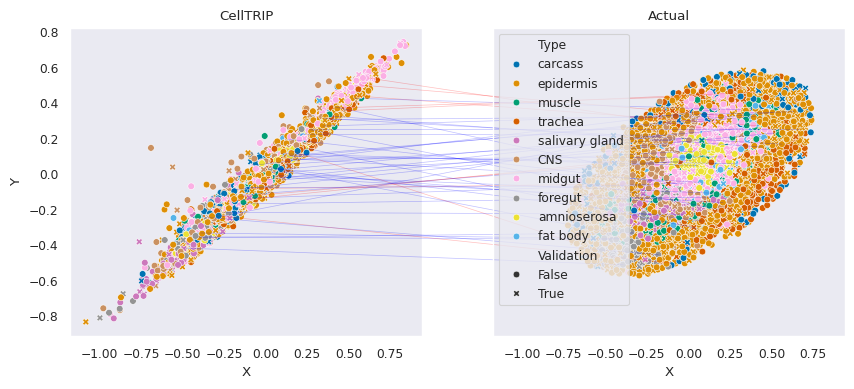

In [22]:
# Plot imputed vs actual
df = pd.DataFrame(index=samples)
df[['X_pred', 'Y_pred']] = reduction(inverse_transform(pinning_function(steady_state)))[..., :2]
df[['X_true', 'Y_true']] = reduction(inverse_transform(target_state.numpy()))[..., :2]
df['Type'] = adatas[0].obs.loc[samples, 'annotation']  # 'target_gene', 'layer', 'pattern_gp_label', 'annotation', 'traj_sim'
df['Validation'] = ~pd.DataFrame(mask, index=adatas[0].obs.index).loc[samples]
# df = df.loc[df['Validation']]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.scatterplot(df, x='X_pred', y='Y_pred', hue='Type', style='Validation', legend=False, ax=axs[0])
sns.scatterplot(df, x='X_true', y='Y_true', hue='Type', style='Validation', legend=True, ax=axs[1])
for i in np.random.choice(df.shape[0], min(50, df.shape[0]), replace=False):
    patch = ConnectionPatch(
        xyA=df.iloc[i][['X_pred', 'Y_pred']].to_numpy(), xyB=df.iloc[i][['X_true', 'Y_true']].to_numpy(),
        coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1],
        color='blue' if not df.iloc[i]['Validation'] else 'red', lw=.5, alpha=.25)
    axs[1].add_patch(patch)
axs[0].set(title='CellTRIP', xlabel='X', ylabel='Y')
axs[1].set(title='Actual', xlabel='X')
fig.show()


In [ ]:
# Intra-type Error
df['MSE'] = np.mean(np.square(inverse_transform(pinning_function(steady_state)) - inverse_transform(target_state.numpy())), axis=-1)
df_mse = df[['Type', 'MSE']].groupby('Type', observed=True).mean()
df_mse['Validation MSE'] = df.loc[df['Validation'], ['Type', 'MSE']].groupby('Type', observed=True).mean()
df_mse


,MSE,Validation MSE
Type,,
CNS,0.110396,0.105846
amnioserosa,0.106050,0.115162
carcass,0.207326,0.216196
epidermis,0.141794,0.140116
fat body,0.131155,0.150417
foregut,0.122795,0.128118
midgut,0.150553,0.141998
muscle,0.150630,0.148212
salivary gland,0.116646,0.131245


: 

In [ ]:
%%manim -qm -v WARNING LatentSpaceVisualization

positions = (
    sklearn.decomposition
    .PCA(n_components=2)
    .fit(steady_state)
    .transform(
        ret[-1].cpu()[..., :env.dim]
        .reshape((-1, env.dim)))
    .reshape((*ret[-1].shape[:-1], 2)))
speedup = 100

class LatentSpaceVisualization(ma.Scene):
    def construct(self):
        # Axes
        spread = 50
        ax = ma.Axes(
            x_range=[-spread, spread, 10], y_range=[-spread, spread, 10],
            x_length=7, y_length=7, tips=False)
        self.add(ax)

        # Time
        t = ma.ValueTracker(0)

        # Dot
        def dot_updater(i):
            return lambda x: x.move_to(ax.c2p(*positions[int(t.get_value()), i]))
        for i in range(positions.shape[1]):
            dot = ma.Dot(
                ax.c2p(*positions[0, i]),
                radius=.02)
            dot.add_updater(dot_updater(i))
            self.add(dot)

        # Animate
        self.play(t.animate.set_value(ret[-1].shape[0]-1), rate_func=ma.linear, run_time=positions.shape[0]*env.delta/speedup)

100% significant correlations


IndexError: index 0 is out of bounds for axis 0 with size 0

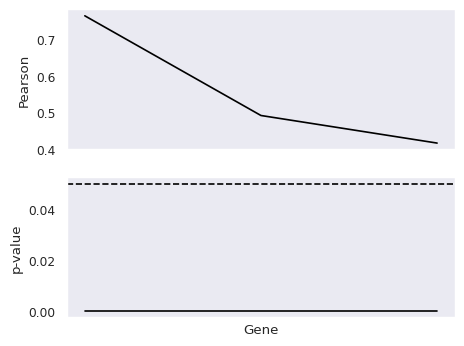

In [16]:
# Calculate correlations
Y_pred = inverse_transform(pinning_function(steady_state))
Y_true = inverse_transform(target_state.numpy())
record = {'gene': [], 'corr': [], 'p': []}
for i in range(Y_true.shape[1]):
    res = scipy.stats.pearsonr(Y_pred[:, i], Y_true[:, i])
    corr, p = res.statistic, res.pvalue
    record['gene'].append(adatas[0].var.index[i])
    record['corr'].append(corr)
    record['p'].append(p)
df = pd.DataFrame(record)
sig_frac = (df.dropna()['p'] <= 5e-2).mean()
print(f'{100*sig_frac:.0f}% significant correlations')

# Distribution plot
df_sort = df.dropna().sort_values('corr', ascending=False)
fig, axs = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
axs[0].plot(df_sort['gene'], df_sort['corr'], color='black')
axs[0].set(ylabel='Pearson')
axs[1].plot(df_sort['gene'], df_sort['p'], color='black')
axs[1].set(ylabel='p-value', xlabel='Gene', xticks=[])
axs[1].axhline(y=5e-2, ls='--', color='black')

# Specific scatter
# idx = df['corr'].sort_values().dropna().iloc[::-1].index[0]
idx = np.argwhere(df['gene'] == 'TMSB4X').flatten()[0]
# idx = np.argwhere(df['gene'] == 'TADA1').flatten()[0]
# idx = np.argwhere(df['gene'] == 'PRCP').flatten()[0]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# Main scatter
ax.scatter(Y_true[:, idx], Y_pred[:, idx], s=1, color='black')
# Extra text
corr, p = df.iloc[idx][['corr', 'p']]
ax.text(.01, .99, f'Pearson: {corr:.3f}\np-value: {p:.2e}', ha='left', va='top', transform=ax.transAxes)
# Add y=x line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set(title=adatas[0].var.index[idx], xlabel='Observed', ylabel='CellTRIP')


In [ ]:
ret[-1][-1][..., env.dim:].mean(dim=0)


In [ ]:
steady_state.mean(dim=0)


In [ ]:
def gene_perturbation(adata, steady_state, genes_to_perturb, preprocessing, modality=0, factor=0):  # adatas[0][samples_flt1], max_steps=1_000
    # Set up env
    env.reset()
    env.set_positions(steady_state.to(env.device))
    env.set_velocities(0*env.get_velocities())
    # Find feature
    features = [np.argwhere(adata.var.index == gene).flatten()[0] for gene in genes_to_perturb]
    # Get knockdowns
    iso_modality = preprocessing.transform(adata.X[:], subset_features=features, subset_modality=modality)[0]  # TODO: Send to pramod with [:] addition
    iso_modality = torch.tensor(iso_modality).to(env.device)
    env.modalities[modality] -= iso_modality - factor*iso_modality
    # Simulate
    ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)

    return ret[-1]

# Permute
group_pert = gene_perturbation(adatas[0][samples], steady_state, ['TMSB4X'], preprocessing, modality=0, factor=0)

# Plot imputed vs actual
df = pd.DataFrame(index=samples)
df[['X_init', 'Y_init']] = reduction(inverse_transform(pinning_function(group_pert[0, :, :env.dim])))[..., :2]
df[['X_final', 'Y_final']] = reduction(inverse_transform(pinning_function(group_pert[-1, :, :env.dim])))[..., :2]
df['Type'] = adatas[0].obs.loc[samples, 'target_gene']  # 'target_gene', 'layer', 'pattern_gp_label', 'annotation'
df['Validation'] = ~pd.DataFrame(mask, index=adatas[0].obs.index).loc[samples]
# df = df.loc[df['Validation']]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.scatterplot(df, x='X_init', y='Y_init', hue='Type', style='Validation', legend=False, ax=axs[0])
sns.scatterplot(df, x='X_final', y='Y_final', hue='Type', style='Validation', legend=True, ax=axs[1])
for i in np.random.choice(df.shape[0], min(50, df.shape[0]), replace=False):
    patch = ConnectionPatch(
        xyA=df.iloc[i][['X_init', 'Y_init']].to_numpy(), xyB=df.iloc[i][['X_final', 'Y_final']].to_numpy(),
        coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1],
        color='blue' if not df.iloc[i]['Validation'] else 'red', lw=.5, alpha=.25)
    axs[1].add_patch(patch)
axs[0].set(title='Steady State', xlabel='X', ylabel='Y')
axs[1].set(title='Perturbed (TMSB4X)', xlabel='X')
fig.show()


In [ ]:
# Permute
start_state = steady_state.clone()
start_state[0] = start_state[600]  # 600 for VCC, 1 for MERFISH
# Set to steady state
env.reset()  # .store_vals().set_termination_conds(exclusive=True, max_time=True) ; env.max_time = 10
env.set_velocities(0*env.get_velocities())
env.set_positions(start_state.to('cuda'))
# Run and reset
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
transition_states = ret[-1][..., :env.dim].cpu()

# Convert select points to feature space
use_states = list(map(int, np.linspace(0, transition_states.shape[0]-1, 9)))
filtered_transition_states = transition_states[use_states]
pinned_transition_states = reduction(
    inverse_transform(
        pinning_function(
            filtered_transition_states.reshape((-1, env.dim))
        )
    )
).reshape((*filtered_transition_states.shape[:-1], -1))

# Get timepoints
dfs = []
for i, timepoint in enumerate(use_states):
    timepoint = int(timepoint)
    dfs.append(pd.DataFrame(index=samples))
    dfs[-1][['X', 'Y']] = pinned_transition_states[i]
    dfs[-1]['Type'] = adatas[0].obs.loc[samples, 'target_gene']
    dfs[-1]['Timepoint'] = timepoint
    dfs[-1]['Perturbed'] = False
    dfs[-1].loc[samples[0], 'Perturbed'] = True
df = pd.concat(dfs, axis=0)
# Plot
fig, axs = plt.subplots(3, 3, figsize=(15, 6), sharex=True, sharey=True)
axs = axs.flatten()
unique_timepoints = df['Timepoint'].unique()
target_point = 0; target_point_positions = []
for i, timepoint in enumerate(unique_timepoints):
    df_filter = df.loc[df['Timepoint'] == timepoint]
    target_point_positions.append(df_filter.loc[[samples[target_point]]])
    sns.scatterplot(df_filter, x='X', y='Y', hue='Type', alpha=.4, legend=False, ax=axs[i])
    for j in range(i):
        axs[i].arrow(
            *target_point_positions[j][['X', 'Y']].to_numpy().flatten(),
            *(target_point_positions[j+1][['X', 'Y']].to_numpy() - target_point_positions[j][['X', 'Y']].to_numpy()).flatten(),
            color='red', lw=1)
    sns.scatterplot(df_filter.loc[[samples[target_point]]], x='X', y='Y', color='blue', alpha=1., legend=False, ax=axs[i])
    axs[i].set(title=f'{timepoint*env.delta:.1f}s', xlabel='X', ylabel='Y')
fig.show()


In [ ]:
assert False


# Running out-of-scope data

In [ ]:
# Load the external dataset
adata = celltrip.utility.processing.read_adatas(
    # 's3://nkalafut-celltrip/MERFISH_Bench/expression.h5ad', backed=True)[0]
    '../data/MERFISH_Bench/sc_data.h5ad', backed=True)[0]
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# Subset and preprocess the data (Use partition cols here to select data)
samples = adata.obs.index
m1, = preprocessing.transform(adata[samples].X, subset_modality=0)
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, dim=8).eval().to('cuda')
# env.set_modalities(...); env.reset()  # Change modalities
policy = celltrip.policy.create_agent_from_env(env, pinning_modal_dims=[2]).eval().to('cuda')  # pinning=False for lstq pinning
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [ ]:
# Run policy to convergence
env.disable_rewards(); env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
steady_state = ret[-1][-1][:, :env.dim].cpu()
# Get pinning and inverse
pinning_function = lambda X: policy.pinning[0](X.to('cuda')).detach().cpu().numpy()
inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=1)[0]


In [ ]:
# inverse_transform = lambda X: X


In [ ]:
# Plot imputed
df = pd.DataFrame(index=samples)
df[['X_pred', 'Y_pred']] = inverse_transform(pinning_function(steady_state))[..., :2]
df[['X_true', 'Y_true']] = adata.obs['spot'].str.split('x', expand=True).astype(float)
df['Type'] = adata.obs['cellType']  # pattern_gp_label, HMRF_k3_b.40
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.scatterplot(df, x='X_pred', y='Y_pred', hue='Type', legend=False, ax=axs[0])
sns.scatterplot(df, x='X_true', y='Y_true', hue='Type', legend=True, ax=axs[1])
axs[0].set(title='CellTRIP', xlabel='X', ylabel='Y')
axs[1].set(title='Actual', xlabel='X')
fig.show()
